In [38]:
import pandas as pd
import matplotlib.pyplot as plt


> Please feel free to leave comments for **suggestions or questions**, and if you find my work helpful, don't forget to **upvote**!

In [39]:
df = pd.read_csv("upwork-jobs.csv")


In [55]:
df.columns


Index(['title', 'link', 'description', 'published_date', 'is_hourly',
       'hourly_low', 'hourly_high', 'budget', 'country', 'title_lower'],
      dtype='object')

In [57]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53058 entries, 0 to 53057
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           53058 non-null  object 
 1   link            53058 non-null  object 
 2   description     53058 non-null  object 
 3   published_date  53058 non-null  object 
 4   is_hourly       44829 non-null  object 
 5   hourly_low      22956 non-null  float64
 6   hourly_high     22161 non-null  float64
 7   budget          21873 non-null  float64
 8   country         51917 non-null  object 
 9   title_lower     53058 non-null  object 
dtypes: float64(3), object(7)
memory usage: 4.0+ MB


# Demographics and summary statistics

Text(0.5, 0, 'Number of job postings')

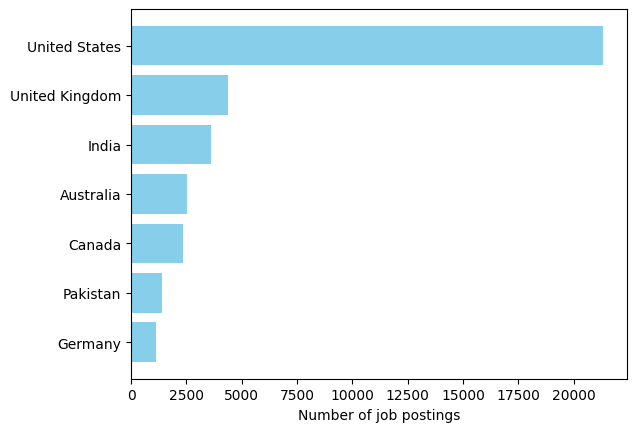

In [40]:
df_country_count = df['country'].value_counts()
df_country_count = df_country_count[df_country_count>1000]
plt.barh(df_country_count.index, df_country_count.values, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Number of job postings')


<BarContainer object of 2 artists>

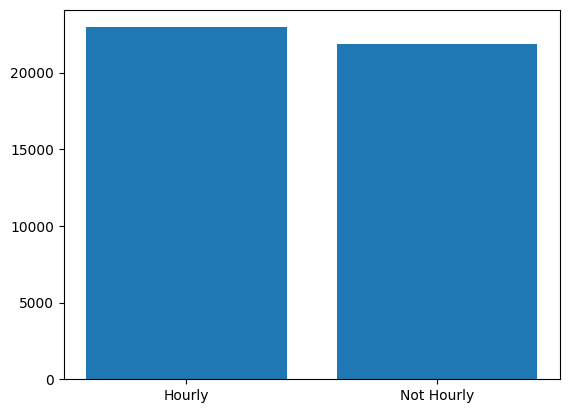

In [41]:
df_is_hourly = df['is_hourly'].value_counts()
df_is_hourly.index = ['Hourly', 'Not Hourly']
plt.bar(df_is_hourly.index, df_is_hourly.values)


(0.0, 200.0)

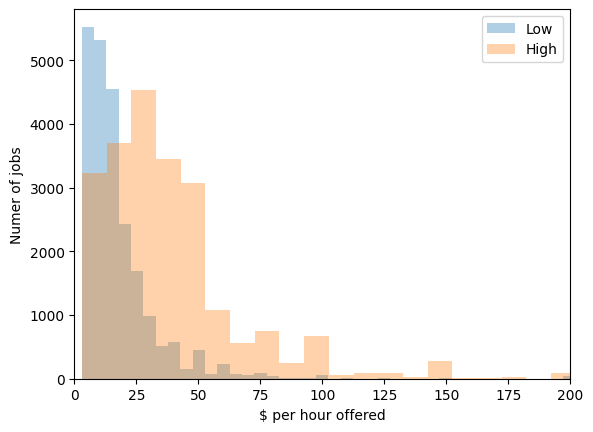

In [42]:
df_gigs_low = df[(df['is_hourly'] == True) & (df['hourly_low'] > 0)]['hourly_low']
df_gigs_high = df[(df['is_hourly'] == True) & (df['hourly_low'] > 0)]['hourly_high']

plt.hist(df_gigs_low, bins = 100, alpha=0.35)
plt.hist(df_gigs_high, bins = 100, alpha=0.35)
plt.legend(['Low', 'High'])
plt.xlabel('$ per hour offered')
plt.ylabel('Numer of jobs')
plt.xlim((0,200))


Dropping  1061 jobs


Text(0.5, 0, 'Country')

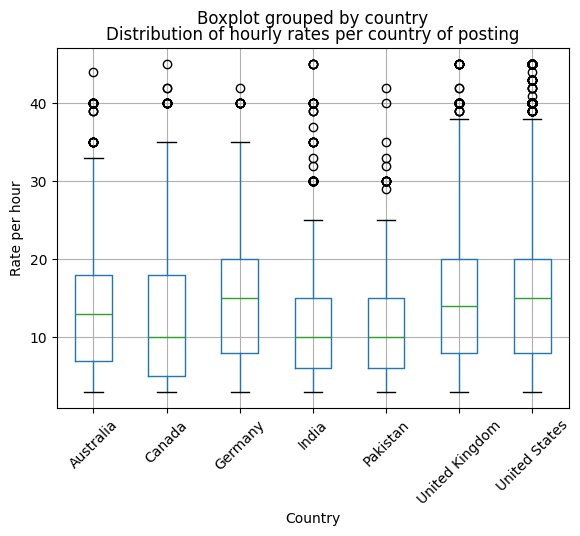

In [43]:
df_top_countries = df[df['country'].isin(df_country_count.index)] # Filter countries with only >1000 jobs

max_minimum_rate = 45
print('Dropping ', df_top_countries[df_top_countries['hourly_low'] > max_minimum_rate].shape[0] , 'jobs')
df_top_countries = df_top_countries[df_top_countries['hourly_low'] <= max_minimum_rate] 

df_top_countries.boxplot(column='hourly_low',by='country')
plt.xticks(rotation=45) 

plt.title('Distribution of hourly rates per country of posting')
plt.ylabel('Rate per hour')
plt.xlabel('Country')


Dropping  1261 jobs


Text(0.5, 0, 'Country')

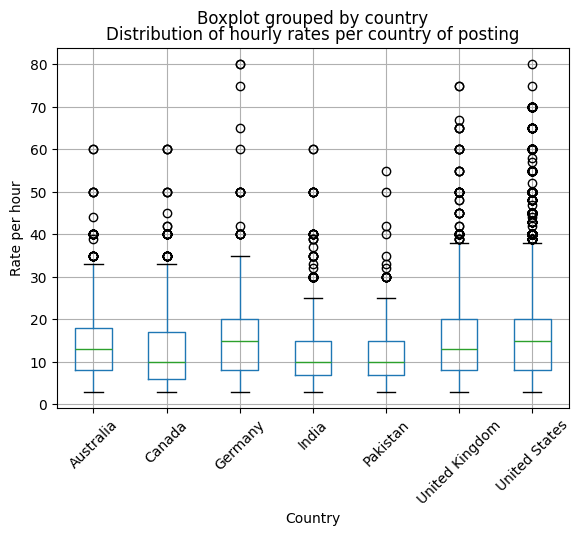

In [44]:
df_top_countries = df[df['country'].isin(df_country_count.index)] # Filter countries with only >1000 jobs

max_minimum_rate = 90
print('Dropping ', df_top_countries[df_top_countries['hourly_high'] > max_minimum_rate].shape[0] , 'jobs')
df_top_countries = df_top_countries[df_top_countries['hourly_high'] <= max_minimum_rate] 

df_top_countries.boxplot(column='hourly_low',by='country')
plt.xticks(rotation=45) 

plt.title('Distribution of hourly rates per country of posting')
plt.ylabel('Rate per hour')
plt.xlabel('Country')


Text(0.5, 1.0, 'Most frequent jobs (without clustering)')

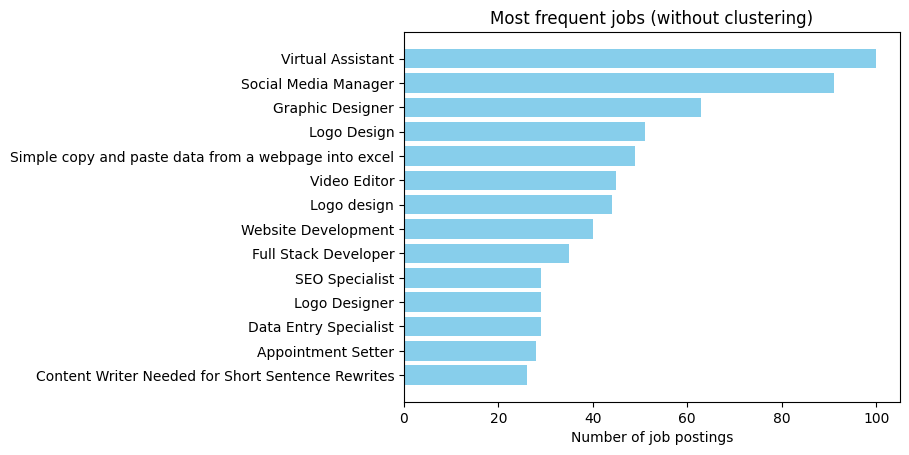

In [45]:
df_title_counts = df['title'].value_counts()
df_title_counts = df_title_counts[df_title_counts>25]
plt.barh(df_title_counts.index, df_title_counts.values, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Number of job postings')
plt.title('Most frequent jobs (without clustering)')


Further work
- Most common jobs by location
- Highest paid jobs by location

# Focus on data jobs
## 1) Attempt to group job titles (Unsupervised clustering using DBSCAN and TF-IDF)

In [46]:
df['title_lower'] = df['title'].str.lower()

data_job_list = ['data engineer', 'data analyst', 'data scientist', 'data']

pattern = '|'.join(data_job_list)
df_data = df[df['title_lower'].str.contains(pattern, case=False, regex=True)]

other_list = ['entry','pull','database']
pattern = '|'.join(other_list)
df_data_entry = df_data[df_data['title'].str.contains(pattern, case=False, regex=True)]

df_data = df_data[~df_data.index.isin(df_data_entry.index)] 


In [47]:
job_titles = list(df_data['title'].values)
print(len(job_titles))
job_titles_test = job_titles#[:1000]


1139


In [51]:
import spacy
spacy.load('en_core_web_sm')


In [52]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# # Remove words with numbers
# cleaned_titles = [word for word in job_titles_test if not any(char.isdigit() for char in word)]
cleaned_titles = job_titles_test

# Preprocess job titles (#### test other cleaning methods for example stop words)
nlp = spacy.load('en_core_web_sm')
cleaned_titles = [' '.join([token.text for token in nlp(title.lower()) if not token.is_punct]) for title in cleaned_titles]

# Convert job titles to TF-IDF vectors (#### test other numerical vector techniques e.g. Word2Vec, GloVe, Doc2Vec)
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
#vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(cleaned_titles)


In [53]:
df_tfidf = pd.DataFrame(X[0].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df_tfidf = df_tfidf.sort_values('TF-IDF', ascending=False)
df_tfidf


,TF-IDF
data engineer,0.713226
engineer,0.678895
data,0.174388
02,0.000000
pdf remove,0.000000
...,...
doing biomass,0.000000
doing,0.000000
documents spreadsheet,0.000000
documents owners,0.000000


Issue with the vectorisation https://towardsdatascience.com/whats-in-a-word-da7373a8ccb 

Clustering the names of jobs seems a limited approach (further testing of other approaches required)

In [54]:
# Apply K-means clustering             (#### test other algorithms e.g. Kmeans)
for eps in [0.99]:
    for min_samples in [2]:
        print(f'--------- eps: {eps} & min_sample:{min_samples} ---------')
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(X)

        # Add cluster labels to DataFrame
        cluster_labels = db.labels_
        print(len(job_titles_test), len(cluster_labels))
        result_df = pd.DataFrame({'Job Title': job_titles_test, 'Cluster': cluster_labels})

        if result_df['Cluster'].nunique() > 1:
            # Calculate silhouette score
            silhouette_avg = silhouette_score(X, cluster_labels)

            print("Silhouette Score:", silhouette_avg)

            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            print("Estimated number of clusters: %d" % n_clusters_)
            print("Estimated number of noise points: %d" % n_noise_)
        else:
            print("Only one cluster found")


--------- eps: 0.99 & min_sample:2 ---------
1139 1139
Silhouette Score: 0.09913950427151906
Estimated number of clusters: 67
Estimated number of noise points: 790


The above was the best possible clustering, but still many job titles missing clusters